In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

# Create Spool

In [ ]:
from JIN_pylib.readers import ONYX_DAS_Reader

sp = ONYX_DAS_Reader.create_spool(datapath)
sp.save_pickle('windows_disk1_2.5khz.pkl')

# Standard Deviation Processing

In [ ]:
def std(DASdata, down_size=60):
    output_data = DASdata.copy()
    data = []
    N = len(DASdata.taxis)//down_size
    for i in range(down_size):
        data.append(np.std(DASdata.data[:,i*N:(i+1)*N], axis=1))
    output_data.data = np.array(data).T
    output_data.taxis = np.array([DASdata.taxis[i*N+N//2] for i in range(down_size)])
    return output_data

def pre_process(DASdata):
    output_data = DASdata.copy()
    output_data.take_gradient()
    return output_data

from JIN_pylib import Spool

sp = Spool.spool()
sp.load_pickle('./windows_disk2_2.5khz.pkl')

Spool.sp_process(sp, './std_test/', std,pre_process=pre_process, patch_size=60, overwrite=False)

# Low frequency downsampling

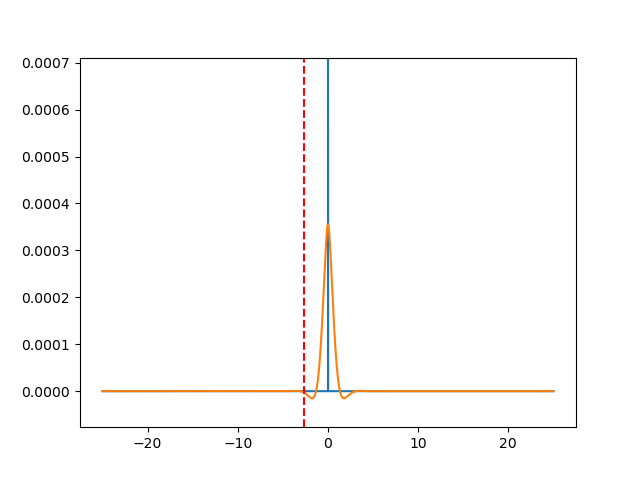

down_sample_ratio: 2500
edge_size: 2.6204
over_lap: 8.0


In [6]:
# Please use this cell to help to setup the processing parameters

from JIN_pylib import gjsignal

threshold = 1e-2 # threshold of error, ratio of filtered signal amplitude

# original data sampling rate
origin_rate = 2500
dt = 1/origin_rate

# targeted sampling rate
new_rate = 1

down_sample_ratio = int(np.ceil(1/dt/new_rate))
corf = new_rate*0.4

plt.figure()
edge_size = gjsignal.find_lpf_edge_effect(corf,dt,threshold, isfigure=True)
over_lap = np.ceil(edge_size*1.5*2)
plt.show()

print('down_sample_ratio:', down_sample_ratio)
print('edge_size:', edge_size)
print('over_lap:', over_lap)


In [ ]:
over_lap = 8  # better to be even number

def down_sample(DASdata, down_sample_ratio=2500):
    output_data = DASdata.copy()
    output_data.select_depth(600,1100)
    output_data.down_sample(down_sample_ratio, edge_size=over_lap/2)
    return output_data

# set to None is not needed
def pre_process(DASdata):
    output_data = DASdata.copy()
    output_data.take_gradient()
    return output_data

# set to None is not needed
def post_process(DASdata):
    output_data = DASdata.copy()
    taxis = output_data.taxis
    output_data.select_time(taxis[0]+over_lap/2, taxis[-1]-over_lap/2)
    return output_data

# make sure the patch size is as large as the memory can afford. Larger patch size will be faster.
Spool.sp_process(sp, './LFDAS/', down_sample
                 ,pre_process=pre_process, post_process=post_process
                 ,patch_size=60, overlap=over_lap
                 ,overwrite=False)

# STALTA processing

In [ ]:
from JIN_pylib import Data2D_XT

sta = 0.1; lta = 1

def pre_process(data):
    data.select_depth(950,1030)
    data.take_gradient()
    data.bp_filter(10, 500)
    return data

def stalta(data):
    t, snr = data.get_stalta(sta, lta)
    out = Data2D_XT.Data2D()
    out.data = snr.reshape((1, -1))
    out.set_time_from_datetime(t)
    out.daxis = np.array([1000])
    out.select_time(lta+sta/2, out.taxis[-1]-sta/2)
    return out

Spool.sp_process(sp, './STALTA/', stalta
                 ,pre_process=pre_process
                 ,patch_size=60, overlap=sta+lta
                 ,overwrite=False)